# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances, find_nearest_orbits_batch, calculate_pairwise_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [3]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

# Parameters

In [4]:
want_to_train = False   # Set this parameter to False if you want to load the model from the folder
want_to_generate = False    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = False   # Set this parameter to False if you don't want to calculate any metric
want_to_generate_latent_space = True    # Set this parameter to False if you don't wan't to generate the latent space
want_to_get_cluster_metrics = True    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = True   # Set this parameter to False if you don't want to perform convergence

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 20
}

# Saving paths

In [7]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_12


In [8]:
# Images
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [10]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [11]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [12]:
model = get_model(params)

In [13]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

## Generate

In [14]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

(100, 7, 100)

# Analysis of Generation

## Visualization

In [15]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

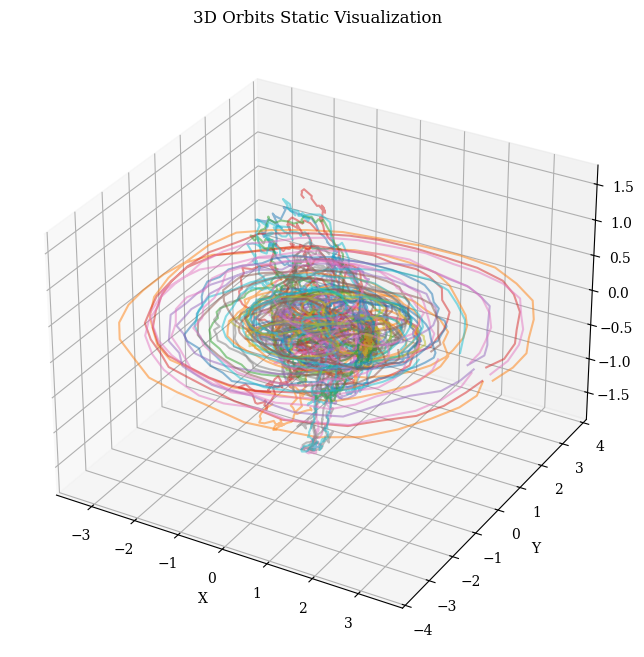

In [16]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

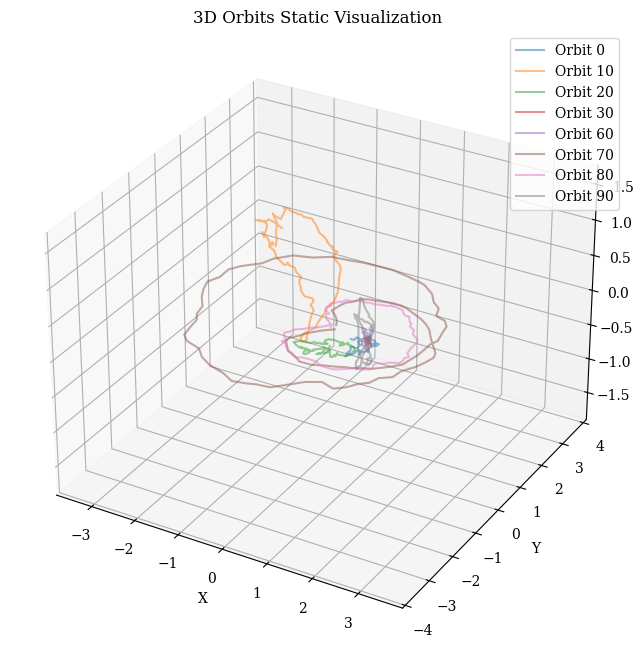

In [17]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [18]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_12/images/exp12_generated_orbits.html


## Coverage

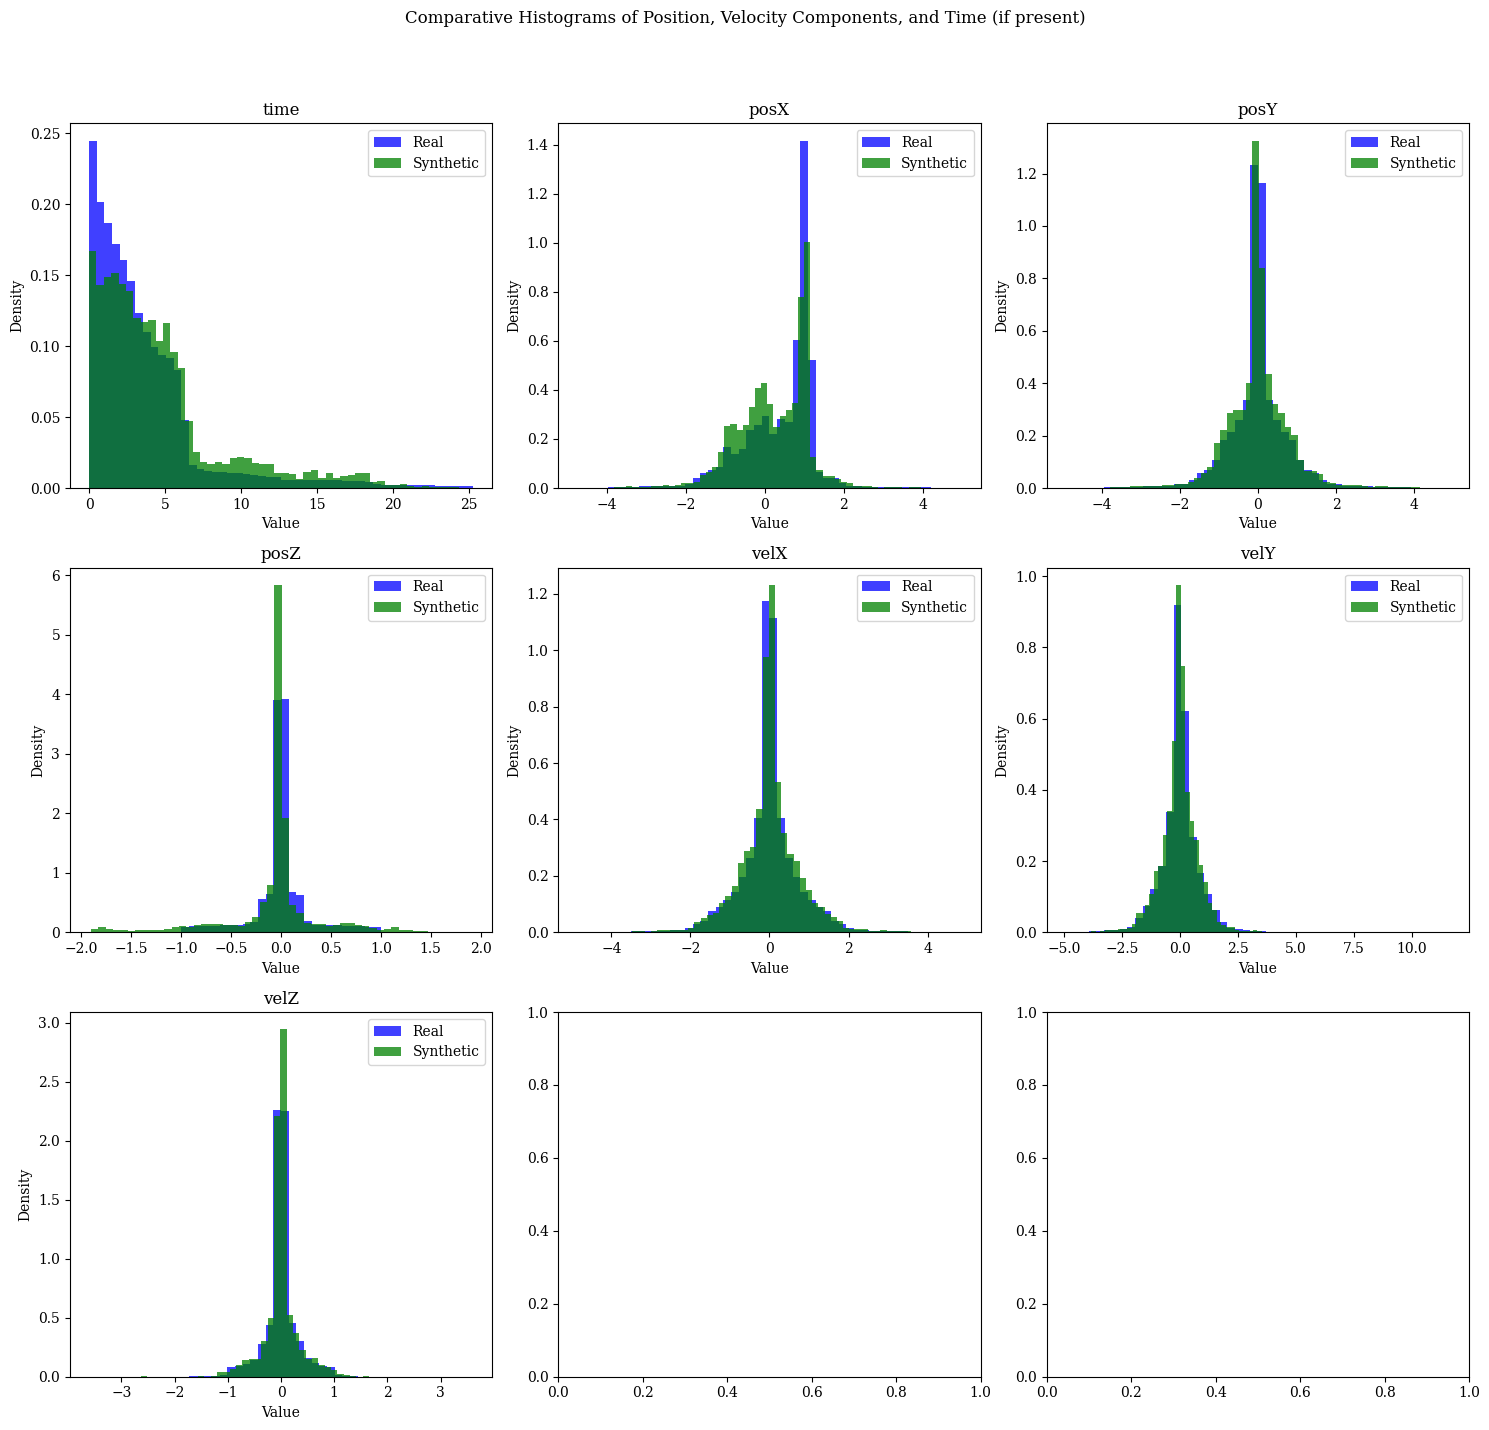

In [19]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

In [20]:

if calculate_error_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation)
    per_orbit_errors = calculate_errors_per_orbit(reordered_orbits,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **order_metrics})

# Latent Space

In [21]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)



(45211, 4)

In [22]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

In [23]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroids_representation.shape

(40, 2)

In [24]:
unique_classes = list(set(orbits_id_classes))
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

## Visualize

Dataset

Saved plot to ../experiments/experiment_12/images/exp12_latent_space


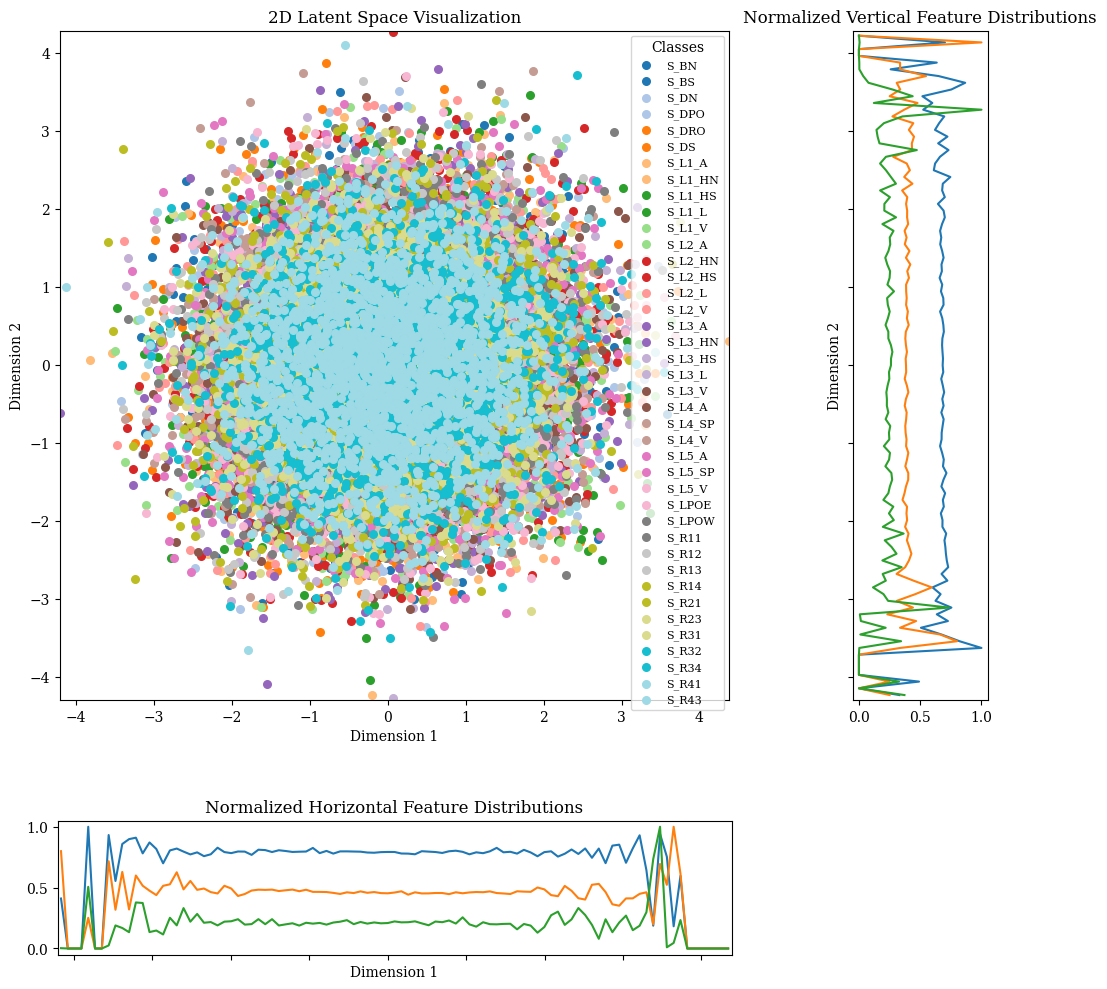

In [25]:
if want_to_generate_latent_space:
    if latent_means.shape[1]==2:
        plot_2d_latent_space(latent_means,
                             np.array(family_labels),
                             save_path=latent_space_path,
                             features=features,
                             feature_names=feature_names)
    else:
        rls=reduce_dimensions_latent_space(latent_means,
                                           np.array(family_labels),
                                           techniques=['PCA','UMAP','t-SNE'],
                                           save_path=latent_space_path,
                                           show_legend=False)


Centroids

Saved plot to ../experiments/experiment_12/images/exp12_family_centroids


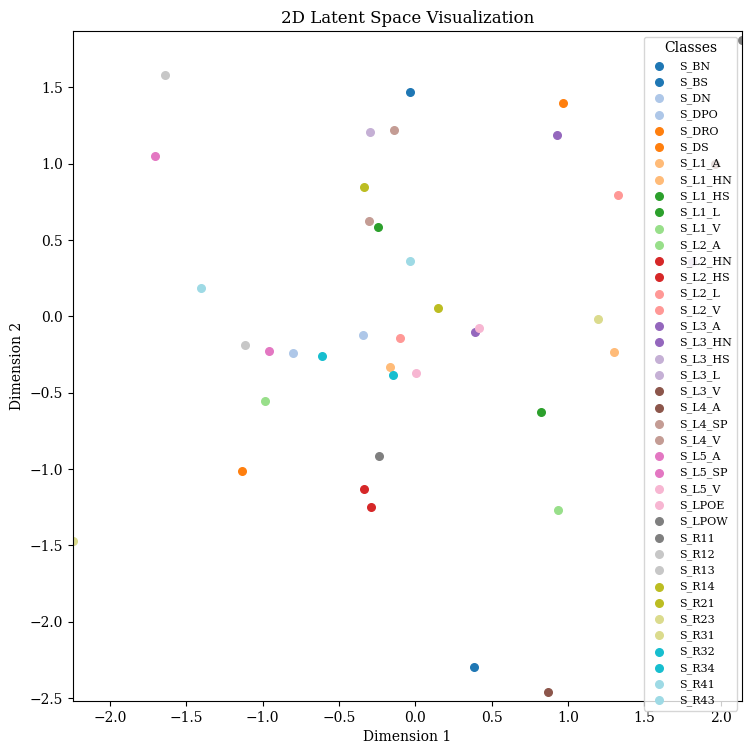

In [26]:
if want_to_generate_latent_space:
    if latent_means.shape[1]==2:
        plot_2d_latent_space(centroid_means,
                             np.array(family_names),
                             save_path=family_centroids_plot_path)
    else:
        rls=reduce_dimensions_latent_space(centroid_means,
                                           np.array(family_names),
                                           techniques=['PCA','UMAP','t-SNE'],
                                           save_path=family_centroids_plot_path,
                                           show_legend=False)

## Clustering

In [27]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

Metrics added to experiment with ID 12 in ../experiments/experiments.json.


# Convergence

In [28]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
else:
    pass ####load

INFO:orbit_generation.convergence:Processing orbit 1/100
INFO:orbit_generation.convergence:Orbit 0: Success=1, Norm=5.723257669675615e-12, Iterations=10
INFO:orbit_generation.convergence:Processing orbit 2/100
INFO:orbit_generation.convergence:Orbit 1: Success=1, Norm=5.940533272330816e-12, Iterations=9
INFO:orbit_generation.convergence:Processing orbit 3/100
INFO:orbit_generation.convergence:Orbit 2: Success=1, Norm=7.0879138004741e-12, Iterations=9
INFO:orbit_generation.convergence:Processing orbit 4/100
INFO:orbit_generation.convergence:Orbit 3: Success=1, Norm=8.047228994655228e-12, Iterations=12
INFO:orbit_generation.convergence:Processing orbit 5/100
INFO:orbit_generation.convergence:Orbit 4: Success=1, Norm=7.860964679780561e-10, Iterations=10
INFO:orbit_generation.convergence:Processing orbit 6/100
INFO:orbit_generation.convergence:Orbit 5: Success=1, Norm=5.475296213421115e-13, Iterations=10
INFO:orbit_generation.convergence:Processing orbit 7/100
INFO:orbit_generation.converg

In [29]:
refined_orbits = np.transpose(refined_orbits,(0,2,1))
np.save(generated_data_path, generation.detach().numpy())
refined_orbits.shape

(41, 7, 100)

In [30]:
generation_df = pd.DataFrame(per_orbit_errors)
generation_df.head()

NameError: name 'per_orbit_errors' is not defined

In [43]:
refined_orbits_df.head()

,id,old_period,new_period,iterations_convergence,error,pos_x0,pos_y0,pos_z0,vel_x0,vel_y0,vel_z0
0,2.0,6.348769,6.311056,8.0,8.170653e-10,0.724026,0.435854,5.338609e-01,0.814150,-1.622988,2.131926e-01
1,4.0,18.210407,17.822647,11.0,4.091293e-12,0.758843,0.097509,-1.774103e-15,0.095262,0.674450,2.800786e-15
2,5.0,24.626577,25.183559,8.0,4.100514e-11,3.705281,0.072228,4.297126e-11,0.065610,-3.327296,1.357003e-11
3,10.0,10.952934,10.906589,7.0,6.873462e-12,0.692369,-0.067674,3.116010e-14,0.005554,0.547222,2.725087e-14
4,13.0,5.315282,3.619671,11.0,4.742243e-12,0.797006,0.143057,-9.735460e-02,-0.084086,0.407244,-2.277034e-01


In [44]:
ids = refined_orbits_df.astype(int).to_list()
generated_data_that_was_refined = generation[ids]
generated_data_that_was_refined.shape

(46, 7, 100)

Generation that was able to get Refined

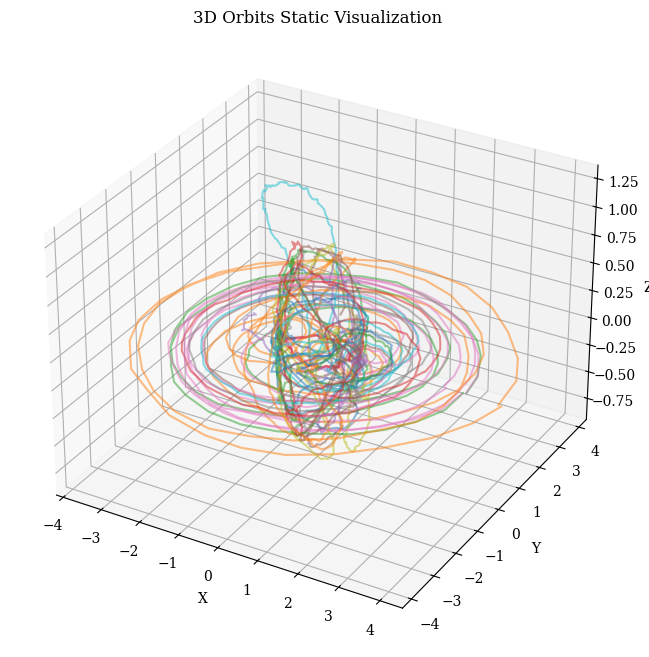

In [46]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

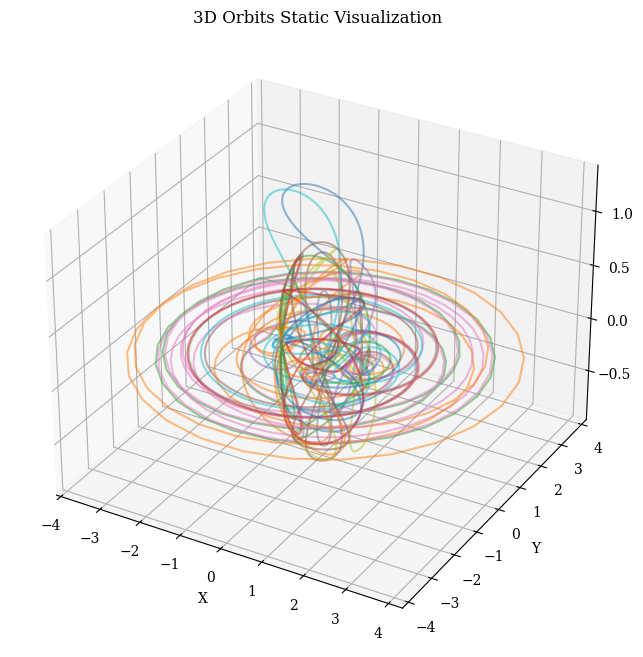

In [49]:
visualize_static_orbits(refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [ ]:
####

In [ ]:
#### plot two examples of generation / refinement

## Latent Space

In [ ]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_representations = refined_latent_means.detach().numpy()
refined_latent_representations.shape

Saved plot to ../experiments/experiment_11/images/exp11_combined_latent_space


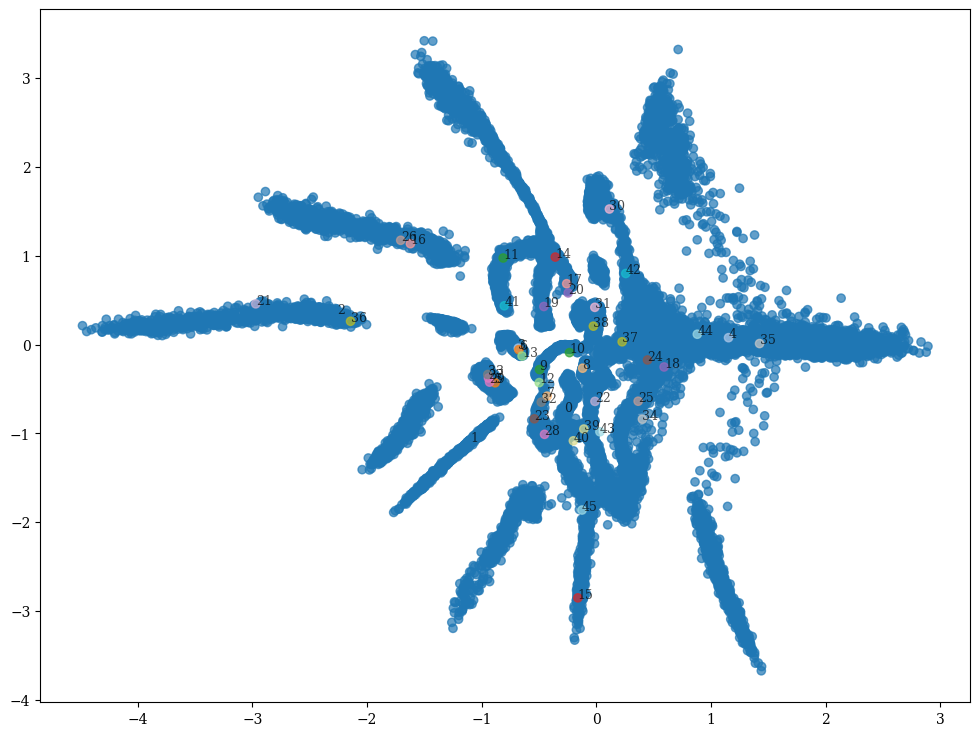

In [75]:
if want_to_study_converged_orbits:
    if refined_latent_representations.shape[1]>2:
        rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                           val_latent=refined_latent_representations)
        latent_representation=rls['PCA']['train']
        refined_latent_representations=rls['PCA']['val']

    plot_combined_2d_latent_space(
        real_latent=latent_means, 
        synthetic_latent=refined_latent_representations,
        synthetic_labels=list(range(0, len(refined_scaled_data))),
        annotation_mode='numbers',
        save_path=combined_latent_space_path
    )


In [ ]:
### plot how far away we are from each convergence and generation in the latent space

## Check Novelty

Calculate Jacobi Constant on the dataset

In [79]:
np.transpose(data,(0,2,1)).shape

(45211, 100, 7)

In [81]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [82]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbit_df['calculated_jacobi'] = new_jacobis
refined_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbit_df.head()

,id,old_period,period,iterations_convergence,error,pos_x0,pos_y0,pos_z0,vel_x0,vel_y0,vel_z0,calculated_jacobi
0,2.0,6.348769,6.311056,8.0,8.170653e-10,0.724026,0.435854,5.338609e-01,0.814150,-1.622988,2.131926e-01,-0.624084
1,4.0,18.210407,17.822647,11.0,4.091293e-12,0.758843,0.097509,-1.774103e-15,0.095262,0.674450,2.800786e-15,2.773315
2,5.0,24.626577,25.183559,8.0,4.100514e-11,3.705281,0.072228,4.297126e-11,0.065610,-3.327296,1.357003e-11,3.211436
3,10.0,10.952934,10.906589,7.0,6.873462e-12,0.692369,-0.067674,3.116010e-14,0.005554,0.547222,2.725087e-14,3.068114
4,13.0,5.315282,3.619671,11.0,4.742243e-12,0.797006,0.143057,-9.735460e-02,-0.084086,0.407244,-2.277034e-01,2.924941


Compare Features between Dataset and Refinement

In [ ]:
features = ['period', 'calculated_jacobi']

feature_distances = calculate_closest_feature_distances(orbit_df, refined_orbit_df, features)
refined_orbit_df['feature_distance_from_closest'] = feature_distances

## Calculate distances

In [90]:
##### remove time

In [ ]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(generated_data,
                                                                                     data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation
generation_df.head()

In [ ]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(refined_orbits,
                                                                                                     data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbit_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbit_df['nearest_orbit_distance'] = nearest_distances_refined_generation
refined_orbit_df.head()

In [ ]:
pairwise_distances = calculate_pairwise_distances(generated_data,
                                                  refined_orbits,
                                                  distance_metric=params['distance_metric'])
refined_orbit_df['distance_from_generation'] = pairwise_distances

In [ ]:
### distance from the centre

In [ ]:
#### distance from closest centroid

# Intelligent Sampling

In [ ]:
interpolate_sample(centroids, granularity=10, variance=0.0)